In [22]:
import numpy as np
import pandas as pd
from kospi_predict import Crawler
from kospi_predict import DataPreprocessor

crawler = Crawler(crawl_page_max=30, perPage=100)
crawler.loadFromSavedFile(["KOSPI"])
df_crawled = crawler.df[100:]
dpp = DataPreprocessor(df_crawled, ["KOSPI"])
dpp.sortByDate()
dpp.df

,date,KOSPI
0,2001-01-02,520.95
1,2001-01-03,521.43
2,2001-01-04,558.02
3,2001-01-05,580.85
4,2001-01-08,586.65
...,...,...
5135,2021-10-14,2988.64
5136,2021-10-15,3015.06
5137,2021-10-18,3006.68
5138,2021-10-19,3029.04


In [23]:
def makeHistoryLabelData(df, history_cnt = 10):
    history_cols = []
    for d_cnt in range(0, history_cnt):
        col_name = "D-{}".format(d_cnt)
        if d_cnt == 0:
            col_name = "D"
        history_cols.append(col_name)

    calc_result = []
    for item in df.iterrows():
        if item[0] >= history_cnt:
            this_result = {
                "date" : df.loc[item[0], "date"]
            }
            this_form = ""
            for i in range(0, history_cnt):
                this_cate = 0
                if (df.loc[item[0]-i, "KOSPI"] - df.loc[item[0]-i-1, "KOSPI"]) > 0:
                    this_cate = 1
                this_result[history_cols[i]] = this_cate
                this_form = this_form+str(this_cate)
            this_result["form"] = this_form

            if item[0]+1 < len(df):
                this_next_day_cate = 0
                if (df.loc[item[0], "KOSPI"] - df.loc[item[0]+1, "KOSPI"]) > 0:
                    this_next_day_cate = 1
                this_result["D+1"] = this_next_day_cate
                calc_result.append(this_result)
    df_calc_history = pd.DataFrame(calc_result)
    combinations = df_calc_history["form"].unique()
    print("총 조합의 갯수 : {}개".format(len(combinations))) #이론적으로는 2의 10승 = 1024개
    return df_calc_history, combinations

df_calc_history, combinations = makeHistoryLabelData(dpp.df, history_cnt = 10)
df_calc_history

총 조합의 갯수 : 1008개


,date,D,D-1,D-2,D-3,D-4,D-5,D-6,D-7,D-8,D-9,form,D+1
0,2001-01-16,1,1,1,1,0,1,1,1,1,1,1111011111,1
1,2001-01-17,0,1,1,1,1,0,1,1,1,1,0111101111,0
2,2001-01-18,1,0,1,1,1,1,0,1,1,1,1011110111,0
3,2001-01-19,1,1,0,1,1,1,1,0,1,1,1101111011,0
4,2001-01-22,1,1,1,0,1,1,1,1,0,1,1110111101,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5124,2021-10-13,1,0,0,1,0,0,0,1,0,0,1001000100,0
5125,2021-10-14,1,1,0,0,1,0,0,0,1,0,1100100010,0
5126,2021-10-15,1,1,1,0,0,1,0,0,0,1,1110010001,1
5127,2021-10-18,0,1,1,1,0,0,1,0,0,0,0111001000,0


In [24]:
result_prob = []
for combi in combinations:
    this_df = df_calc_history.loc[(df_calc_history["form"] == combi), ["D+1"]]
    up_cnt = this_df["D+1"].sum()
    down_cnt = len(this_df) - up_cnt
    prob_up = up_cnt / len(this_df)
    prob_down = down_cnt / len(this_df)
    result_prob.append({
        "form" : combi,
        "total_cnt" : len(this_df),
        "up_cnt" : up_cnt,
        "down_cnt" : down_cnt,
        "prob_up" : prob_up,
        "prob_down" : prob_down
    })
df_prob = pd.DataFrame(result_prob)
df_prob

,form,total_cnt,up_cnt,down_cnt,prob_up,prob_down
0,1111011111,13,3,10,0.230769,0.769231
1,0111101111,8,1,7,0.125000,0.875000
2,1011110111,12,7,5,0.583333,0.416667
3,1101111011,8,5,3,0.625000,0.375000
4,1110111101,8,5,3,0.625000,0.375000
...,...,...,...,...,...,...
1003,0111000100,1,1,0,1.000000,0.000000
1004,0100101011,2,0,2,0.000000,1.000000
1005,0001001110,1,0,1,0.000000,1.000000
1006,1000100111,1,1,0,1.000000,0.000000


array([[<AxesSubplot:title={'center':'prob_up'}>]], dtype=object)

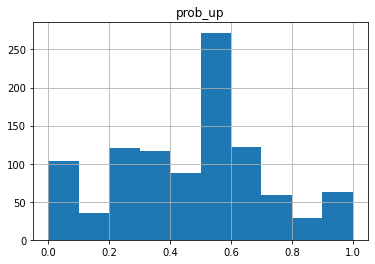

In [25]:
df_prob.hist("prob_up")

최근 데이터(100건)으로 시뮬레이션을 해 본다.

In [32]:
df_test = crawler.df[:100]
dpp_test = DataPreprocessor(df_test, ["KOSPI"])
dpp_test.sortByDate()

df_test_calc_history, _ = makeHistoryLabelData(dpp_test.df, history_cnt = 11)
df_test_calc_history["form"] = df_test_calc_history["form"].str[1:]

df_test_calc_history["prob_up"] = 0.0
df_test_calc_history["prob_down"] = 0.0
df_test_calc_history["predict"] = ""
for item in df_test_calc_history.iterrows():
    this_prob = df_prob.loc[(df_prob["form"]==item[1]["form"]), ["prob_up", "prob_down"]]
    if len(this_prob) > 0:
        this_prob_up = this_prob["prob_up"].values[0]
        this_prob_down = this_prob["prob_down"].values[0]
        this_predict_label = 0
        this_predict = "하락"
        if this_prob_up > this_prob_down:
            this_predict_label = 1
            this_predict = "상승"
        elif this_prob_up == this_prob_down:
            this_predict_label = np.nan
            this_predict = "알 수 없음"
        df_test_calc_history.loc[item[0], "prob_up"] = this_prob_up
        df_test_calc_history.loc[item[0], "prob_down"] = this_prob_down
    else:
        this_predict = "알 수 없음"
    df_test_calc_history.loc[item[0], "predict"] = this_predict
    df_test_calc_history.loc[item[0], "predict_label"] = this_predict_label
    this_result = 0
    if df_test_calc_history.loc[item[0], "predict_label"] == df_test_calc_history.loc[item[0], "D"]:
        this_result = 1
    df_test_calc_history.loc[item[0], "result"] = this_result

drop_index = df_test_calc_history[(df_test_calc_history["predict_label"].isnull())].index
df_test_calc_history.drop(index=drop_index, inplace=True)
print("score : {:.2f}점".format(100*df_test_calc_history["result"].sum()/len(df_test_calc_history)))
df_test_calc_history

총 조합의 갯수 : 88개
score : 43.66점


,date,D,D-1,D-2,D-3,D-4,D-5,D-6,D-7,D-8,D-9,D-10,form,D+1,prob_up,prob_down,predict,predict_label,result
0,2021-11-05,0,1,0,1,1,0,0,0,1,1,0,1011000110,1,0.666667,0.333333,상승,1.0,0.0
2,2021-11-09,1,0,0,1,0,1,1,0,0,0,1,0010110001,1,0.333333,0.666667,하락,0.0,0.0
3,2021-11-10,0,1,0,0,1,0,1,1,0,0,0,1001011000,1,0.666667,0.333333,상승,1.0,0.0
4,2021-11-11,0,0,1,0,0,1,0,1,1,0,0,0100101100,0,0.750000,0.250000,상승,1.0,0.0
5,2021-11-12,1,0,0,1,0,0,1,0,1,1,0,0010010110,0,0.600000,0.400000,상승,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,2022-03-08,0,0,0,1,1,1,1,0,1,0,0,0011110100,0,0.333333,0.666667,하락,0.0,1.0
83,2022-03-10,1,0,0,0,1,1,1,1,0,1,0,0001111010,1,0.571429,0.428571,상승,1.0,1.0
84,2022-03-11,0,1,0,0,0,1,1,1,1,0,1,1000111101,1,0.250000,0.750000,하락,0.0,1.0
85,2022-03-14,0,0,1,0,0,0,1,1,1,1,0,0100011110,1,0.666667,0.333333,상승,1.0,0.0
